<a href="https://colab.research.google.com/github/KevinSassani/DINOv2-Project/blob/main/Food101_sample_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import datasets
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from glob import glob
from PIL import Image
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
dinov2_vits14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 194MB/s]
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_linear4_head.pth" to /root/.cache/torch/hub/che

100%|██████████| 5.00G/5.00G [04:13<00:00, 19.7MB/s]


Extracting food101/food-101.tar.gz to food101


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

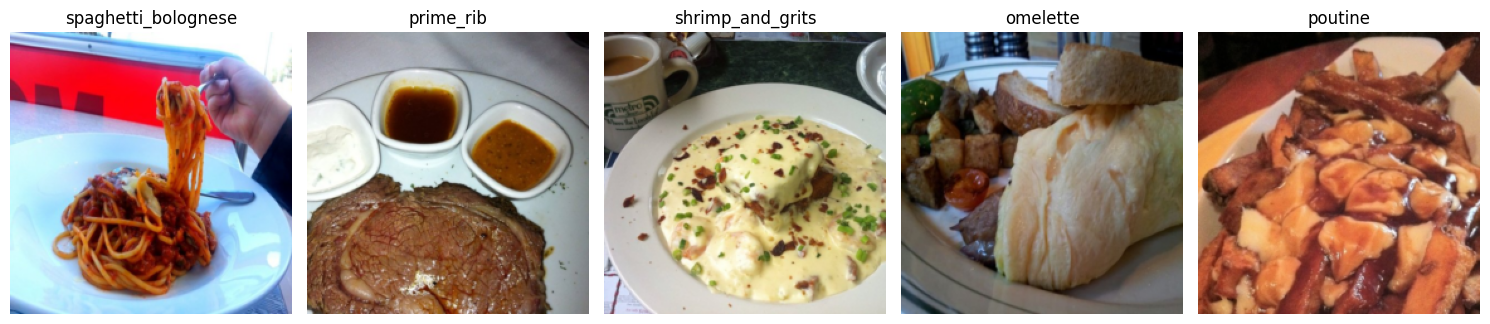

In [4]:
batch_size = 1
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors and normalize to [0, 1]
])

train_data = torchvision.datasets.Food101(root='food101', split='train', download=True, transform=transform)
test_data = torchvision.datasets.Food101(root='food101', split='test', download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
# Randomly select 5 samples
random_indices = random.sample(range(len(train_data)), 5)
samples = [train_data[idx] for idx in random_indices]

# Plot the samples
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, (image, label) in enumerate(samples):
    axs[i].imshow(image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
    axs[i].axis('off')  # Turn off axes
    axs[i].set_title(train_data.classes[label])  # Set the title to the class name

plt.tight_layout()
plt.show()

In [23]:
from torch.utils.data import Subset
batch_size = 16

class_is_taken = {}
one_sample_per_class = []
class_to_index = {}

idx_list = list(range(len(train_data)))
random.shuffle(idx_list)

for i in range(len(idx_list)):
    idx = idx_list[i]
    _, label = train_data[idx]
    if label not in class_to_index:
        class_to_index[label] = idx
    if len(class_to_index) == len(train_data.classes):
        break

subset_indices = list(class_to_index.values())
small_train_subset = Subset(train_data, subset_indices)
small_train_loader = DataLoader(small_train_subset, batch_size=batch_size, shuffle=True)

for idx, data_index in enumerate(subset_indices):
    _, label = train_data[data_index]
    print(f"Class: {train_data.classes[label]}, Index: {data_index}")


Class: spring_rolls, Index: 3951
Class: spaghetti_carbonara, Index: 49592
Class: chicken_quesadilla, Index: 68358
Class: fried_calamari, Index: 48788
Class: steak, Index: 15885
Class: french_fries, Index: 53586
Class: peking_duck, Index: 41147
Class: guacamole, Index: 41507
Class: paella, Index: 15520
Class: sushi, Index: 57866
Class: french_onion_soup, Index: 44590
Class: bibimbap, Index: 11919
Class: beet_salad, Index: 33442
Class: croque_madame, Index: 44104
Class: nachos, Index: 74525
Class: ice_cream, Index: 71975
Class: lobster_roll_sandwich, Index: 74165
Class: pancakes, Index: 31896
Class: sashimi, Index: 2413
Class: lasagna, Index: 40001
Class: strawberry_shortcake, Index: 42077
Class: clam_chowder, Index: 43292
Class: deviled_eggs, Index: 37488
Class: gnocchi, Index: 22515
Class: pad_thai, Index: 8976
Class: huevos_rancheros, Index: 66873
Class: grilled_cheese_sandwich, Index: 73314
Class: hamburger, Index: 56043
Class: bread_pudding, Index: 21740
Class: pork_chop, Index: 330

In [54]:
batch_size = 16

class_to_indices = {}

idx_list = list(range(len(train_data)))
random.shuffle(idx_list)

for i in range(len(idx_list)):
    idx = idx_list[i]
    _, label = train_data[idx]
    if label not in class_to_indices:
        class_to_indices[label] = []
    if len(class_to_indices[label]) < 10:
        class_to_indices[label].append(idx)
    if all(len(indices) == 10 for indices in class_to_indices.values()):
        break

subset_indices = list(class_to_index.values())
small_train_subset_10 = Subset(train_data, subset_indices)
small_train_loader_10 = DataLoader(small_train_subset_10, batch_size=batch_size, shuffle=True)

# for idx, data_index in enumerate(subset_indices):
#     _, label = train_data[data_index]
#     print(f"Class: {train_data.classes[label]}, Index: {data_index}")


In [49]:
test_subst_indices = list(range(len(test_data)))
random.shuffle(test_subst_indices)
test_subset_indices = test_subst_indices[:int(len(test_data)/10)]

test_data_subset = Subset(test_data, test_subset_indices)
test_loader_subset = DataLoader(test_data_subset, batch_size=batch_size, shuffle=False)

In [59]:
# Inspect the current classification head
existing_head = dinov2_vits14_lc.linear_head

# Get the shape of the existing head
input_features = existing_head.in_features
output_features = existing_head.out_features

# Initialize a new classification head with random weights
new_head = nn.Linear(input_features, output_features)

print(f"New head initialized with shape: {input_features} -> {output_features}")
import copy

# Deep copy the model
dinov2_vits14_lc_original = copy.deepcopy(dinov2_vits14_lc)
dinov2_vits14_lc.linear_head = new_head

# freeze all weights in the dinov2_vits14_lc_copy except the new head
for param in dinov2_vits14_lc.parameters():
    param.requires_grad = False

# unfreeze the new head
for param in dinov2_vits14_lc.linear_head.parameters():
    param.requires_grad = True

# save_checkpoint('/checkpoints',dinov2_vits14_lc,0)

New head initialized with shape: 1920 -> 1000


In [9]:
def test_accuracy(model,test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [60]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vits14_lc.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dinov2_vits14_lc.linear_head.parameters(), lr=1e-3)
epochs = 100
epoch = 0

test_accuracy_list = []

for i in range(epochs):
    dinov2_vits14_lc.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(enumerate(small_train_loader_10), total=len(small_train_loader_10), desc=f"Epoch {i+1}/{epochs}")
    for idx, (images, labels) in progress_bar:
        optimizer.zero_grad()
        # input = processor(images=batch[0], return_tensors="pt")
        input = processor(images=images, return_tensors="pt", padding=True).to(device)
        # input = processor(images=batch[0], return_tensors="pt").to(device)
        labels = labels.to(device)
        output = dinov2_vits14_lc(input["pixel_values"])
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # Update progress bar with loss
        progress_bar.set_postfix(loss=loss.item(),accuracy=f"{100*correct/total:.2f}%")
        progress_bar.update(1)


    #print(f"Epoch {i + 1}, Loss: {loss_val.item()}")
    if i % 5 == 0:
        test_acc = test_accuracy(dinov2_vits14_lc,test_loader_subset)
        print(f"Epoch {i + 1}, Test Accuracy: {test_acc}")
        test_accuracy_list.append(test_acc)
        # if test_acc == max(test_accuracy_list):
        #     save_checkpoint(dinov2_vits14_lc,optimizer,loss_function,test_acc,i,is_best=True)
        # else:
        #     save_checkpoint(dinov2_vits14_lc,optimizer,loss_function,test_acc,i)


Epoch 1/100: 100%|██████████| 7/7 [00:01<00:00,  3.88it/s, accuracy=0.00%, loss=14]


Epoch 1, Test Accuracy: 0.011881188118811881


Epoch 6/100: 100%|██████████| 7/7 [00:01<00:00,  4.94it/s, accuracy=56.44%, loss=1.6]


Epoch 6, Test Accuracy: 0.009900990099009901


Epoch 11/100: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s, accuracy=87.13%, loss=1.6]


Epoch 11, Test Accuracy: 0.009900990099009901


Epoch 16/100: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s, accuracy=95.05%, loss=0.259]


Epoch 16, Test Accuracy: 0.009108910891089108


Epoch 21/100: 100%|██████████| 7/7 [00:01<00:00,  3.64it/s, accuracy=96.04%, loss=0.269]


Epoch 21, Test Accuracy: 0.008712871287128714


Epoch 26/100: 100%|██████████| 7/7 [00:01<00:00,  4.97it/s, accuracy=99.01%, loss=0.189]


Epoch 26, Test Accuracy: 0.009504950495049505


Epoch 31/100: 100%|██████████| 7/7 [00:01<00:00,  4.95it/s, accuracy=100.00%, loss=0.0611]


Epoch 31, Test Accuracy: 0.008316831683168317


Epoch 36/100: 100%|██████████| 7/7 [00:01<00:00,  5.00it/s, accuracy=100.00%, loss=0.0797]


Epoch 36, Test Accuracy: 0.009108910891089108


Epoch 41/100: 100%|██████████| 7/7 [00:01<00:00,  4.98it/s, accuracy=100.00%, loss=0.0962]


Epoch 41, Test Accuracy: 0.009108910891089108


Epoch 46/100: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s, accuracy=100.00%, loss=0.0425]


Epoch 46, Test Accuracy: 0.009108910891089108


Epoch 51/100: 100%|██████████| 7/7 [00:01<00:00,  4.64it/s, accuracy=100.00%, loss=0.0203]


Epoch 51, Test Accuracy: 0.008712871287128714


Epoch 56/100: 100%|██████████| 7/7 [00:01<00:00,  4.77it/s, accuracy=100.00%, loss=0.0624]


Epoch 56, Test Accuracy: 0.009504950495049505


Epoch 61/100: 100%|██████████| 7/7 [00:01<00:00,  4.97it/s, accuracy=100.00%, loss=0.0264]


Epoch 61, Test Accuracy: 0.009108910891089108


Epoch 66/100: 100%|██████████| 7/7 [00:01<00:00,  4.33it/s, accuracy=100.00%, loss=0.0164]


Epoch 66, Test Accuracy: 0.009108910891089108


Epoch 71/100: 100%|██████████| 7/7 [00:01<00:00,  4.35it/s, accuracy=100.00%, loss=0.0247]


Epoch 71, Test Accuracy: 0.009504950495049505


Epoch 76/100: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s, accuracy=100.00%, loss=0.0198]


Epoch 76, Test Accuracy: 0.009504950495049505


Epoch 81/100: 100%|██████████| 7/7 [00:01<00:00,  4.66it/s, accuracy=100.00%, loss=0.0169]


Epoch 81, Test Accuracy: 0.009900990099009901


Epoch 86/100: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s, accuracy=100.00%, loss=0.0133]


Epoch 86, Test Accuracy: 0.009108910891089108


Epoch 91/100: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s, accuracy=100.00%, loss=0.00693]


Epoch 91, Test Accuracy: 0.009900990099009901


Epoch 96/100: 100%|██████████| 7/7 [00:01<00:00,  4.37it/s, accuracy=100.00%, loss=0.0074]


Epoch 96, Test Accuracy: 0.009900990099009901


Epoch 100/100: 100%|██████████| 7/7 [00:01<00:00,  4.90it/s, accuracy=100.00%, loss=0.00716]


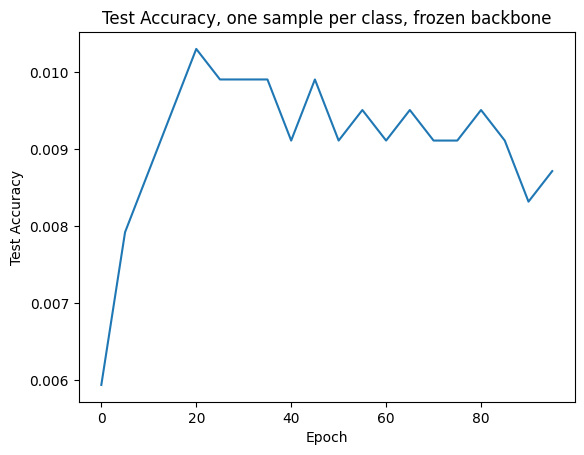

In [42]:
x = range(0, 100, 5)
plt.plot(x, test_accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy, one sample per class, frozen backbone")
plt.savefig("one_sample_per_class_frozen_backbone.png")
plt.show()

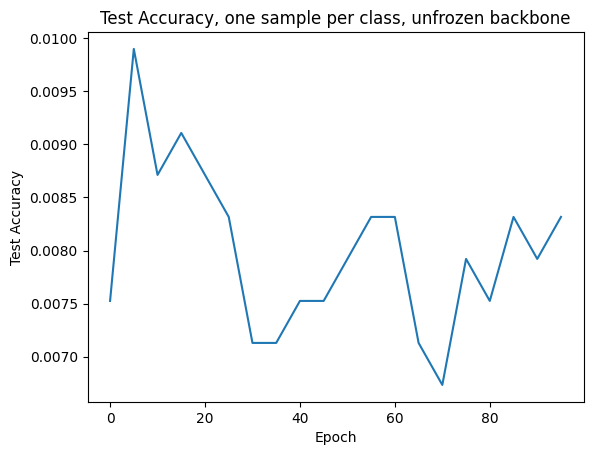

In [52]:
plt.plot(x, test_accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy, one sample per class, unfrozen backbone")
plt.savefig("one_sample_per_class_unfrozen_backbone.png")
plt.show()

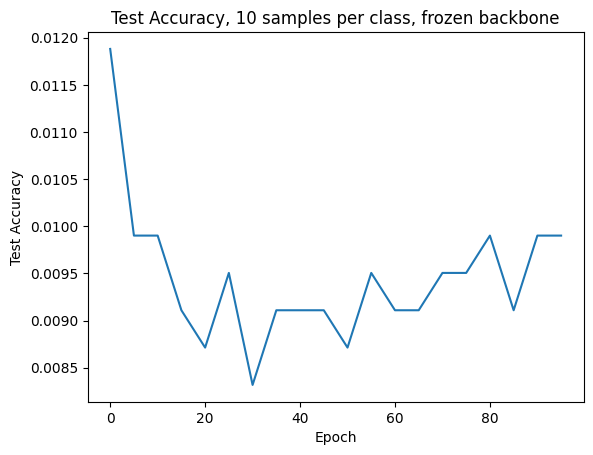

In [61]:
plt.plot(x, test_accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy, 10 samples per class, frozen backbone")
plt.savefig("10_samples_per_class_frozen_backbone.png")
plt.show()

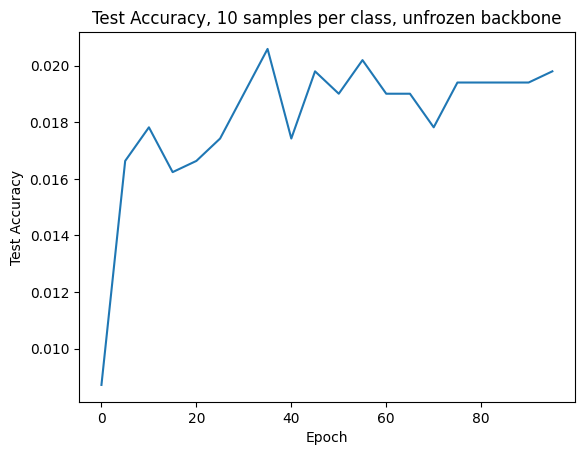

In [58]:
plt.plot(x, test_accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy, 10 samples per class, unfrozen backbone")
plt.savefig("10_samples_per_class_unfrozen_backbone.png")
plt.show()